In [1]:
# Import libraries 
%matplotlib inline

import math
import glob, os
import pandas as pd 
import numpy as np
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams

from tqdm import tqdm_notebook


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from pandas.plotting import autocorrelation_plot
from math import sqrt
from matplotlib import pyplot

import itertools
from functools import reduce

import random
from sklearn.model_selection import ParameterGrid
from fbprophet.plot import plot_plotly, plot_components_plotly
import holidays

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import warnings filter
from warnings import simplefilter


from fbprophet import Prophet
np.warnings.filterwarnings('ignore')



In [2]:
import sys
print(sys.executable)

C:\Users\abebu\DS\envs\ZA\python.exe


In [3]:
files = glob.glob('Data/*.csv')
emerging_stocks = pd.concat([pd.read_csv(stocks).assign(filename=os.path.basename(stocks).split('.')[0]) for stocks in files]).reset_index()
emerging_stocks

,index,Date,Price,Open,High,Low,Vol.,Change %,filename
0,0,31-Mar-21,85.15,86.5,88.1,85.15,564.30K,-1.10%,Argentina - Pampa Energia SA (PAMP)
1,1,30-Mar-21,86.1,85.15,86.75,84.6,141.40K,1.29%,Argentina - Pampa Energia SA (PAMP)
2,2,29-Mar-21,85.0,80.0,86.0,79.0,371.22K,3.85%,Argentina - Pampa Energia SA (PAMP)
3,3,26-Mar-21,81.85,84.0,84.6,80.7,462.55K,-2.09%,Argentina - Pampa Energia SA (PAMP)
4,4,25-Mar-21,83.6,85.2,87.3,82.1,389.78K,-3.13%,Argentina - Pampa Energia SA (PAMP)
...,...,...,...,...,...,...,...,...,...
2496,310,8-Jan-20,19.94,19.89,19.95,19.66,2.79M,0.05%,Turkey - Koc Holding AS (KCHOL)
2497,311,7-Jan-20,19.93,20.22,20.28,19.92,2.89M,-0.75%,Turkey - Koc Holding AS (KCHOL)
2498,312,6-Jan-20,20.08,20.34,20.34,19.97,1.94M,-1.08%,Turkey - Koc Holding AS (KCHOL)
2499,313,3-Jan-20,20.3,20.3,20.44,19.97,3.31M,-0.39%,Turkey - Koc Holding AS (KCHOL)


In [4]:


#### Input params ##################
stk_path = "./data/Turkey - Koc Holding AS (KCHOL).csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [5]:

def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'price'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [6]:
df = pd.read_csv(stk_path)

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# # Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,price,open,high,low,vol.,change_%,month
314,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.30%,1
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.39%,1
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-1.08%,1
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.75%,1
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.05%,1
309,2020-01-09,20.42,20.20,20.58,20.08,7.94M,2.41%,1
308,2020-01-10,20.54,20.54,20.70,20.26,4.38M,0.59%,1
307,2020-01-13,20.80,20.52,20.86,20.50,4.50M,1.27%,1
306,2020-01-14,20.94,20.80,20.96,20.62,4.06M,0.67%,1
305,2020-01-15,20.86,20.86,21.28,20.54,4.93M,-0.38%,1


## Split into train, valdation and test set
`Split dataset into 60% train, 20% validation, and 20% test. The model will be trained using the train set, model hyperparameters will be tuned using the validation set, and finally the performance of the model will be reported using the test set.`

In [14]:

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df)) # proportion of dataset to be used as cross-validation set
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 189
num_cv = 63
num_test = 63
train.shape = (189, 8)
cv.shape = (63, 8)
train_cv.shape = (252, 8)
test.shape = (63, 8)


# Facebook’s PROPHET


Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The mathematical equation behind the Prophet model is defined as:
`y(t) = g(t) + s(t) + h(t) + e(t)`

- `g(t)` representing the trend. Prophet uses a piecewise linear model for trend forecasting.
- `s(t)` represents periodic changes (weekly, monthly, yearly).
- `h(t)` represents the effects of holidays (recall: Holidays impact businesses).
- `e(t)` is the error term.

In [15]:
fbp_df = df[['date', 'price']]
fbp_train_cv = train_cv[['date', 'price']]
fbp_train = train[['date', 'price']]
fbp_cv = cv[['date', 'price']]
fbp_test = test[['date', 'price']]
fbp_df.shape, fbp_train_cv.shape, fbp_train.shape, fbp_cv.shape, fbp_test.shape


((315, 2), (252, 2), (189, 2), (63, 2), (63, 2))

In [16]:
from sklearn.metrics import mean_squared_error
train_price = fbp_train['price'].values
cv_price = fbp_cv['price'].values
test_price = fbp_test['price'].values
train_cv = fbp_train_cv['price'].values

In [51]:

fbp_train = fbp_train.rename(columns={'date': 'ds', 'price': 'y'})
# The Prophet class (model)
fbp = Prophet(daily_seasonality = True) 
 # Fit the model 
fbp.fit(fbp_train)
# We need to specify the number of days in future
fbp_cv = fbp_cv.rename(columns={'date': 'ds', 'price': 'y'})
fut = fbp.make_future_dataframe(periods=num_cv, freq='D', include_history = False) 
#fut = fbp_cv[['ds']]
model_predictions = fbp.predict(fut)
model_predictions_yhat = model_predictions['yhat'].values

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(cv_price, model_predictions_yhat))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(cv_price, model_predictions_yhat)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE = 5.476
MAPE = 25.208%


In [18]:
model_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,20.448474,20.348451,22.039281,20.448474,20.448474,0.753333,0.753333,0.753333,0.736376,0.736376,0.736376,0.016956,0.016956,0.016956,0.0,0.0,0.0,21.201806
1,2020-01-03,20.408596,20.308362,22.079241,20.408596,20.408596,0.741907,0.741907,0.741907,0.736376,0.736376,0.736376,0.005530,0.005530,0.005530,0.0,0.0,0.0,21.150503
2,2020-01-06,20.288964,20.234082,21.892971,20.288964,20.288964,0.751462,0.751462,0.751462,0.736376,0.736376,0.736376,0.015085,0.015085,0.015085,0.0,0.0,0.0,21.040426
3,2020-01-07,20.249086,20.218000,21.904410,20.249086,20.249086,0.858779,0.858779,0.858779,0.736376,0.736376,0.736376,0.122403,0.122403,0.122403,0.0,0.0,0.0,21.107866
4,2020-01-08,20.209209,20.131733,21.807891,20.209209,20.209209,0.760495,0.760495,0.760495,0.736376,0.736376,0.736376,0.024119,0.024119,0.024119,0.0,0.0,0.0,20.969704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020-11-30,10.987739,9.790508,13.870612,9.287080,12.793603,0.751462,0.751462,0.751462,0.736376,0.736376,0.736376,0.015085,0.015085,0.015085,0.0,0.0,0.0,11.739201
248,2020-12-01,10.949234,9.759569,13.978503,9.204056,12.826216,0.858779,0.858779,0.858779,0.736376,0.736376,0.736376,0.122403,0.122403,0.122403,0.0,0.0,0.0,11.808014
249,2020-12-02,10.910729,9.638164,13.847677,9.112191,12.835559,0.760495,0.760495,0.760495,0.736376,0.736376,0.736376,0.024119,0.024119,0.024119,0.0,0.0,0.0,11.671224
250,2020-12-03,10.872224,9.592021,13.778430,9.029451,12.839514,0.753333,0.753333,0.753333,0.736376,0.736376,0.736376,0.016956,0.016956,0.016956,0.0,0.0,0.0,11.625557


In [52]:
# A better plot than the simple matplotlib
plot_plotly(fbp, model_predictions)

Text(0, 0.5, 'USD')

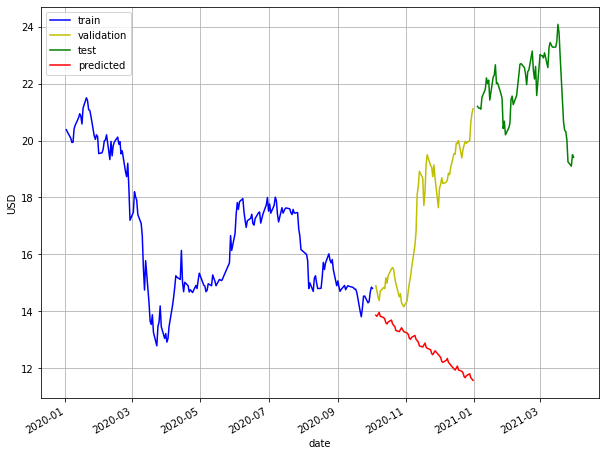

In [56]:

### Plotting predictions from the ARIMA Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est':model_predictions_yhat, 
                       'y_cv': fbp_cv['y'],
                       'date': fbp_cv['ds']})
#est_df['est'] = est_df['est'].str[0]
ax = fbp_train.plot(x='ds', y='y', style='b-', grid=True)
ax = fbp_cv.plot(x='ds', y='y', style='y-', grid=True, ax=ax)
ax = fbp_test.plot(x='ds', y='y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [31]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2020, 2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [34]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Turkey(years=[2020, 2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "Turkey-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [32]:
# Setup and train model with holidays
import holidays
fbp_train = fbp_train.rename(columns={'date': 'ds', 'price': 'y'})
# The Prophet class (model)
fbp = Prophet(holidays=holiday) 
 # Fit the model 
fbp.fit(fbp_train)
# We need to specify the number of days in future
fbp_cv = fbp_cv.rename(columns={'date': 'ds', 'price': 'y'})
fut = fbp.make_future_dataframe(periods=63, freq='D') 
#fut = fbp_cv[['ds']]
model_predictions = fbp.predict(fut)
model_predictions_yhat = model_predictions['yhat'].values

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(train_cv, model_predictions_yhat))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(train_cv, model_predictions_yhat)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE = 2.849
MAPE = 9.001%


In [35]:
# Setup and train model with holidays

fbp_train = fbp_train.rename(columns={'date': 'ds', 'price': 'y'})
# The Prophet class (model)
fbp = Prophet(holidays=holiday) 
 # Fit the model 
fbp.fit(fbp_train)
# We need to specify the number of days in future
fbp_cv = fbp_cv.rename(columns={'date': 'ds', 'price': 'y'})
fut = fbp.make_future_dataframe(periods=63, freq='D') 
#fut = fbp_cv[['ds']]
model_predictions = fbp.predict(fut)
model_predictions_yhat = model_predictions['yhat'].values

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(train_cv, model_predictions_yhat))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(train_cv, model_predictions_yhat)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE = 2.856
MAPE = 9.019%


In [33]:


# A better plot than the simple matplotlib
plot_plotly(fbp, model_predictions)

## Prophet Model Tuning

From the above results, we can see that by adding holidays in the model, model performance further reduced. We need to add other parameters to tune the model.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.

1. Holidays
2. Changepoints: (n_changepoints,changepoint_prior_scale)
3. seasonality_mode
4. holiday_prior_scale
5. Seasonalities with fourier_order

We have added holidays to our model and saw its effect.

**n_changepoints** is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

**changepoint_prior_scale** to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

**seasonality_mode** There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

**holiday_prior_scale** just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

**Seasonalities with fourier_order** Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination. I am taking 4 parameters: **n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale** for tuning.

In [44]:

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3],
              'holidays_prior_scale':[0.1,0.2,0.3],
              'n_changepoints' : [15, 50, 100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 54


In [43]:

strt='2020-01-01'
end='2020-12-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(fbp_train)
    train_forecast = train_model.make_future_dataframe(periods=63, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    model_predictions_yhat = train_forecast['yhat'].values
    cv=train_forecast[['ds','yhat']]
    Actual = fbp_train_cv[(fbp_train_cv['date']>strt) & (fbp_train_cv['date']<=end)]
    MAPE = get_mape(cv_price,model_predictions_yhat)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.94802859036856
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.024251490588256
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.804717646256606
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.486663793152257
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.804717646256606
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.486663793152257
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.76857300578598
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.056380633496037
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.666325340601613
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2,

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.480161095759954
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.666325340601613
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.480161095759954
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.747722612800214
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.011955589040813
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.98991615365353
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3,

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.522842069013556
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.98991615365353
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.522842069013556
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.776381081472735
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.02336514677954
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.68851541552731
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, '

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.502213210334798
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.68851541552731
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.502213210334798
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.932955881389226
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.017919384764014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.811452571950113
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5,

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.491212175367444
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.811452571950113
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.491212175367444
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.30888969314914
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.892032844116383
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.487802321805246
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1,

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.868453291110722
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.487802321805246
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.868453291110722
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.321814923949736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.97829375784082
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.271089997845667
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2,

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.85233617381239
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.271089997845667
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.85233617381239
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.255530743491127
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.99428215038392
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.185716687024167
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.869540092757983
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.185716687024167
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.869540092757983
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.24705909352113
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.98080286169049
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.228150070023762
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.821046613712898
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.228150070023762
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.821046613712898
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.255551263916363
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.993293751876184
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.319600345091803
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.812041724787804
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.319600345091803
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.812041724787804
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 10.363617485795377
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.727599996805857
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.697292342800683
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.006829199777327
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 11.697292342800683
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.006829199777327
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.35525160345557
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 654.8078393825895
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.980085037416206
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 12.754793581698461
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 11.980085037416206
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.754793581698461
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.170886466765445
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.454430003736984
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 10.916469816574557
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.282472004055695
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.916469816574557
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.282472004055695
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.388418559061106
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 442.3152436594926
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.02119395057908
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.773770070076196
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 11.02119395057908
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.773770070076196
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 10.598636070254594
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.73094882291492
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.00573084712317
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, '

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.990788152572128
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 12.00573084712317
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.990788152572128
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 78.20213629910081
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 587.9303002393979
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 88.28119167655417
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 512.3315970985201
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 88.28119167655417
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 512.3315970985201
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 112.07615266229827
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 406.98188757890426
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 113.27208761281666
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 357.1640923961449
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.27208761281666
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 357.1640923961449
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 104.72236594739061
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 436.5380811760817
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 107.19523734183743
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 387.0671665755216
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.19523734183743
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 387.0671665755216
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 41.318990264445944
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 449.73716507728386
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 97.23557016648365
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 552.5215898281224
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 97.23557016648365
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 552.5215898281224
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 110.3663454249698
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 429.01314201784044
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 109.13559713535714
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, '

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 314.58141915864724
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 109.13559713535714
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 314.58141915864724
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.7330778182136
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 483.8074048761849
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 72.32231891453425
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 397.30243855187666
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 72.32231891453425
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 397.30243855187666
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 72.79715983124635
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 480.4899986999143
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.51407459358896
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 502.8736491571572
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 57.51407459358896
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 502.8736491571572
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 70.34709981274246
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 572.9923201942124
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 71.33937513240262
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 513.3807406466443
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.33937513240262
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 513.3807406466443
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 46.45437206213144
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 446.6636102358377
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.56192736125103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 519.5378029488813
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 57.56192736125103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 519.5378029488813
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 47.00682479561577
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 472.58165134550467
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 53.70965529867032
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n

INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 471.61032190844185
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 150.


Mean Absolute Percentage Error(MAPE)------------------------------------ 53.70965529867032
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 471.61032190844185


In [45]:

strt='2020-01-01'
end='2020-12-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(fbp_train)
    train_forecast = train_model.make_future_dataframe(periods=63, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    model_predictions_yhat = train_forecast['yhat'].values
    cv=train_forecast[['ds','yhat']]
    Actual = fbp_train_cv[(fbp_train_cv['date']>strt) & (fbp_train_cv['date']<=end)]
    MAPE = get_mape(cv_price,model_predictions_yhat)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.480905138218954
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.2819125459621
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.907048913459406
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.375403526759143
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE

Mean Absolute Percentage Error(MAPE)------------------------------------ 370.32821604108545
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 10.363617485795377
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.727599996805857
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 816.3810154309697
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 475.2021216118881
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n

In [46]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,10.363617,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
1,11.170886,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
2,11.355252,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
3,13.162271,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
4,14.255531,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [47]:
#Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and 
#predict on test set.

parameters['Parameters'][0]

{'changepoint_prior_scale': 0.3,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

## Final Prophet Model

In [50]:
fbp_train_cv = fbp_train_cv.rename(columns={'date': 'ds', 'price': 'y'})
fbp = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.3,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95) 
 # Fit the model 
fbp.fit(fbp_train_cv)
# We need to specify the number of days in future
fbp_test = fbp_test.rename(columns={'date': 'ds', 'price': 'y'})
fut = fbp.make_future_dataframe(periods=63, freq='D', include_history = False) 
#fut = fbp_cv[['ds']]
model_predictions = fbp.predict(fut)
model_predictions_yhat = model_predictions['yhat'].values

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(test_price, model_predictions_yhat))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(test_price, model_predictions_yhat)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)



RMSE = 1.443
MAPE = 5.052%


Text(0, 0.5, 'USD')

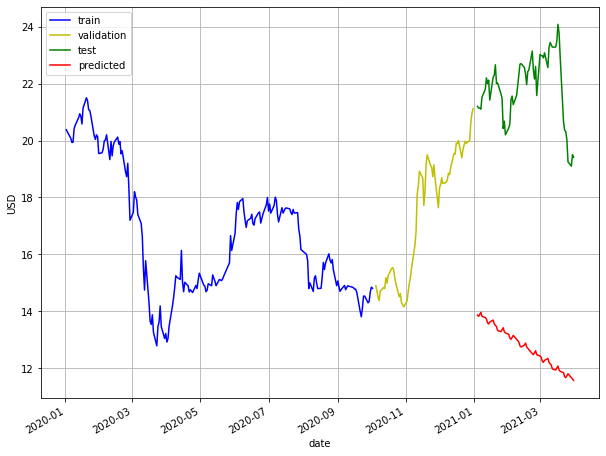

In [69]:
## Final Model - test dataset
### Plotting predictions from the facebook prophet Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': model_predictions_yhat, 
                       'y_test': test_price.reshape(-1),
                       'date': fbp_test['ds']})
#est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = fbp_cv.plot(x='ds', y='y', style='y-', grid=True, ax=ax)
ax = fbp_test.plot(x='ds', y='y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Comparing Models

In [70]:
test_last_value = pd.read_csv('Output/test_last_value.csv', index_col = 0)
test_lstm = pd.read_csv('Output/test_lstm.csv', index_col = 0)
test_mov_avg = pd.read_csv('Output/test_mov_avg.csv', index_col = 0)
test_ARIMA = pd.read_csv('Output/test_ARIMA.csv', index_col = 0)
test_last_value.shape, test_lstm.shape, test_mov_avg.shape, test_ARIMA.shape

((63, 9), (63, 2), (63, 10), (62, 3))

In [ ]:
## Comparing Models
### Plotting predictions from 4 Models
rcParams['figure.figsize'] = 16, 10 

ax = test.plot(x='date', y='price', style='b-', grid=True)
ax = test_merged.plot(x='date', y='est_LV', style='y-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_MA', style='r-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_LSTM', style='g-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_ARIMA', style='c-', grid=True, ax=ax)
ax.legend(['Test_data_actual', 'est_LastValue (RMSE = 0.536)', 'est_Moving_Avg (RMSE = 0.598)', 'est_LSTM (RMSE = 0.690)', 'est_ARIMA (RMSE = 0.559)'])
ax.set_xlabel("date")
ax.set_ylabel("USD")